<a href="https://colab.research.google.com/github/carminight/fornace/blob/master/es12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Esercitazione 12

In [2]:
#Librerie necessarie

import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.layers import Flatten, Conv2D, MaxPooling2D
from PIL import Image
import os
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

## Es 12.1

In questa esercitazione viene affrontato un problema di classificazione. In questa prima fase viene effettuato uno studio di una DNN, presentata di seguito, valutando il valore dell'accuratezza e della funzione costo al variare dell'ottimizzatore utilizzato. Si riporta di seguito il caso per la scelta dello Stochastic Gradient Discend (SGD) per esteso, mentre per le altre scelte degli ottimizzatori si riportato solo il loss test e l'accuracy test.

In [3]:
# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# cast floats to single precesion
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

60000 train samples
10000 test samples


In [4]:
def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


In [13]:
def compile_model():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=SGD(),#Parte che viene modificata
                  metrics=['acc'])
    return model 

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


In [14]:
# training parameters
batch_size = 32
epochs =5

# create the deep neural net
model_DNN = compile_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))


Epoch 1/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.7484 - acc: 0.7793 - val_loss: 0.3099 - val_acc: 0.9123
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3811 - acc: 0.8923 - val_loss: 0.2378 - val_acc: 0.9312
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3093 - acc: 0.9116 - val_loss: 0.1992 - val_acc: 0.9408
Epoch 4/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2655 - acc: 0.9245 - val_loss: 0.1727 - val_acc: 0.9481
Epoch 5/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2328 - acc: 0.9347 - val_loss: 0.1554 - val_acc: 0.9532


313/313 [==============================] - 1s 2ms/step - loss: 0.1554 - acc: 0.9532

Test loss: 0.15542031824588776
Test accuracy: 0.9531999826431274


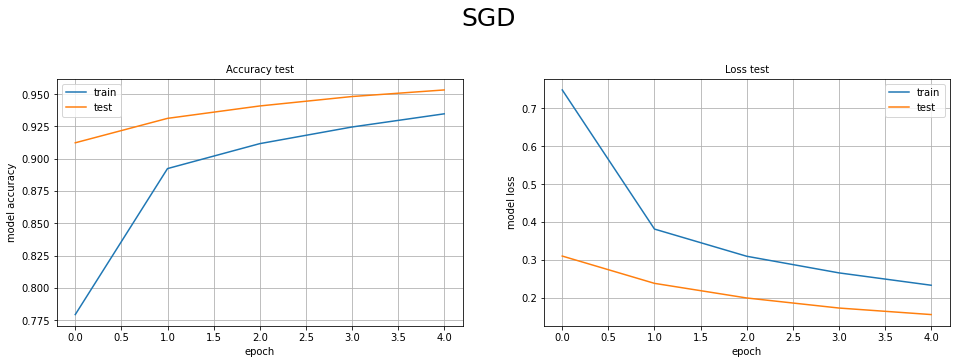

In [16]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history
# summarize history for accuracy
plt.figure(figsize=(16,10))
plt.suptitle('SGD', fontsize = 25)
plt.subplot(2,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy test', fontsize=10)
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()

# summarize history for loss
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss test', fontsize=10)
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

Osservando i risultati ottenuti si evince che SGD e RMSprop siano i peggiori ottimizzatori in questo caso mentre l'ottimizzatore migliore è Adamax poichè è quello che presenta i valori minori per il loss test e quelli maggiori per il accurancy test. Inoltre si può notare che nel caso in cui si sono utilizzati Adam e RMSprop è avvenuto overfitting poichè l'errore sui dati di test inizia ad aumentare.

## Es 12.2

Questa fase dell'esercitazione prevede la creazione di un Convolution Neural Networks (CNN) in grado di riconoscere le cifre scitte contenute MNIST dataset. Di seguito è riportarta la creazione della CNN, il suo training e i risultati ottenuti. (I dati di training e di test sono stati creati all'inizio del notebook).

In [17]:
# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [18]:
def create_CNN():
    # instantiate model
    model = Sequential() #28x28*1
    model.add(Conv2D(10, kernel_size=(5, 5),activation='relu',input_shape=input_shape))  #24*24*10 
    model.add(MaxPooling2D(pool_size=(2,2),strides = 2, padding = 'valid', data_format = None)) #12*12*10  
    model.add(Conv2D(30, kernel_size=(5, 5),activation='relu',input_shape=input_shape)) #8*8*30
    model.add(MaxPooling2D(pool_size=(2,2),strides = 2, padding = 'valid', data_format = None)) #4*4*30
    model.add(Flatten()) 
    model.add(Dense(480, activation='tanh')) 
    model.add(Dropout(0.6))
    model.add(Dense(10, activation='softmax')) #numeri che vanno da 0 a 9
    
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='SGD',
                  metrics=['accuracy'])
    return model

In [20]:
# training parameters
batch_size = 32
epochs = 5

# create the deep conv net
model_CNN=create_CNN()

# train CNN
model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

# evaliate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/5
1875/1875 [==============================] - 40s 22ms/step - loss: 0.4932 - accuracy: 0.8454 - val_loss: 0.1288 - val_accuracy: 0.9609
Epoch 2/5
1875/1875 [==============================] - 41s 22ms/step - loss: 0.1525 - accuracy: 0.9536 - val_loss: 0.0873 - val_accuracy: 0.9718
Epoch 3/5
1875/1875 [==============================] - 41s 22ms/step - loss: 0.1133 - accuracy: 0.9638 - val_loss: 0.0676 - val_accuracy: 0.9779
Epoch 4/5
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0978 - accuracy: 0.9698 - val_loss: 0.0551 - val_accuracy: 0.9825
Epoch 5/5
313/313 [==============================] - 2s 8ms/step - loss: 0.0571 - accuracy: 0.9813

Test loss: 0.057065483182668686
Test accuracy: 0.9812999963760376


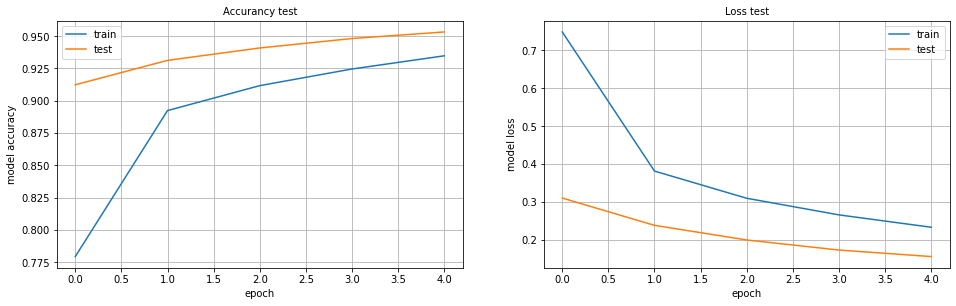

In [21]:

# look into training history
# summarize history for accuracy
plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accurancy test', fontsize=10)
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()

# summarize history for loss
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss test', fontsize=10)
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

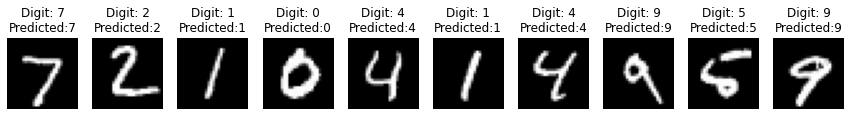

In [22]:
predictions = model_CNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:{}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

L'ultima fase ha riguardato dei test effettuati sulla CNN implementata; si può notare che esse predice correttamente le cifre che le vengono sottoposte.

## Es 12.3

In [23]:
from PIL import Image
import os

digit_filename = "Pictures/12.3/three.png"
digit_in = Image.open(digit_filename).convert('L')

ydim, xdim = digit_in.size
print("Image size: "+str(xdim)+"x"+str(ydim))
pix=digit_in.load();
data = np.zeros((xdim, ydim))
for j in range(ydim):
    for i in range(xdim):
        data[i,j]=pix[j,i]

data /= 255

data = data.reshape(1,xdim*ydim)
pred_0 = model_DNN.predict(data)

data = data.reshape(xdim,ydim)

plt.figure(figsize=(5, 5))  
plt.imshow(data, cmap='gray')    
plt.title("Digit predicted:    {}".format(np.argmax(pred_0)))
plt.axis('off') 
plt.show()

FileNotFoundError: ignored

Durante lo svolgimento dell'esercizio si è notato che la CNN è molto sensibile alla precisione con la quale viene scritta la cifra. Si riportano di seguito alcuni esempi in cui la predizione non è corretta molto probabilmente per il differente modo di scrittura della cifra, per la precisione o per la posizione in cui viene scritta.

Questi comportamenti non si sono riscontrati per tutte le cifre scritte infatti come si può notare di seguito alcuni casi critici hanno ottenuto un risultato favorevole.

Inoltre si è notato che la CNN non è in grado di predire nessun numero se quest'ultimo e ruotato rispetto alla posizione originale. Si riporta di seguito un esempio rappresentativo
